In [1]:
import scipy.io as scio 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import spectral as sp
import numpy as np
import glob
import os 
from sklearn.cluster import KMeans
import skimage as ski 
import skfuzzy as skf
from configparser import ConfigParser
from scipy import ndimage 
import matplotlib.image as mpimg
import sompy

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pavia = {'rgb': scio.loadmat('PaviaRGB.mat')['PaviaRGB'],
         'color_map' : scio.loadmat('PaviaColorMap.mat')['PaviaColorMap'],
         'ground_truth' : scio.loadmat('PaviaGrTruth.mat')['PaviaGrTruth'],
         'ground_truth_mask' : scio.loadmat('PaviaGrTruthMask.mat')['PaviaGrTruthMask'],
         'hyperimage' : scio.loadmat('PaviaHyperIm.mat')['PaviaHyperIm'],
         'wavelengths' : scio.loadmat('PaviaWavelengths.mat')['PaviaWavelengths'],
        }
sanbar = {'rgb': scio.loadmat('SanBarRGB.mat')['SanBarRGB'],
          'wavelengths': scio.loadmat('SanBarWavelengths.mat')['WaveLengths'],
          'hyperimage': scio.loadmat('SanBarHyperIm.mat')['SanBarIm88x400'],
         }

config = ConfigParser()
config.read('appConfig.ini')

def k_means_clustering(inp=pavia['rgb'], n_clusters=2):
    if inp is None:
        print("Empty Input. Exiting")
    k_means = KMeans(n_clusters=n_clusters)
    shape = inp.shape
    k_means.fit(inp.flatten().reshape(shape[0]*shape[1],shape[2]))
    inp_clustered = k_means.labels_.astype(float)
    return inp_clustered.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])

def fuzzy_c_means(n_clusters=2,fuzz_degree=2,error=0.005,max_iter=1000,inp_image=pavia['rgb']):
    shape = inp_image.shape
    centers, u, u0, d, jm, n_iters, fpc = skf.cluster.cmeans(
        inp.flatten().reshape(shape[0]*shape[1],shape[2]).T,
        c=n_clusters,
        m=fuzz_degree,
        error=error,
        maxiter=max_iter,
        init=None,
        seed=config.getint(FCM, SEED)
    )
    clust = np.argmax(u, axis=0).astype(float)
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])

def SOM(n_clusters=5, n_job =5, map_dim=20, inp_image=pavia['rgb']):
    
    # Calculate the map
    mapsize = [map_dim,map_dim]
    shape = inp_image.shape
    data = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    som = sompy.SOMFactory.build(data, mapsize)  
    som.train(n_job=n_job, verbose=None)
    
    #calculating clusters
    cl = som.cluster(n_clusters=n_clusters)
    
    # calculating which pixel is associated which cluster
    project_data = som.project_data(data)
    clust = np.zeros((shape[0], shape[1]))
    for i, q in enumerate(project_data):
        temp = cl[q]
        clust[np.unravel_index(i, dims=((shape[0], shape[1])))] = temp

    return clust

def postprocess(inp_image):
    # Median filter as a post processing step to remove small clusters.
    window_size = int(config['MEDIAN_FILTER']['WINDOW_SIZE'])
    return ndimage.median_filter(inp_image, size=window_size)

In [3]:
def MyClust(image=pavia['rgb'],params={'Algorithm': 'KMeans',
                                       'ImType': 'RGB',
                                       'NumClusts': 3}):
    # Preprocessing Input Image
    #inp_image = preprocess(image)
    
    shape = image.shape
    CCIm = None
    out_labels = None 
    
    if params['ImType'].upper() == 'HYPER':
        # Dimensionality Reduction for Hyperimage 
        n_components = int(config['HYPER']['N_COMPONENTS'])
        hyper = image.flatten().reshape(shape[0]*shape[1],shape[2])
        pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
        image = pca.transform(hyper).reshape(shape[0],shape[1],n_components)
    
    # Resetting Shape in case input was hyper image and underwent dimensionality reduction 
    shape = image.shape
    
    n_clusters = params['NumClusts']
    if params['NumClusts'] > 0.25 * shape[0] * shape[1]:
        print('NumClusts higher than 25% of Number of Pixels\nExiting...')
    elif params['NumClusts'] == 1:
        n_clusters = int(0.05 * shape[0] * shape[1])
    
    
    if params['Algorithm'].upper() == 'KMEANS':
        out_labels = k_means_clustering(inp=image, n_clusters=n_clusters)   
    
    elif params['Algorithm'].upper() == 'FCM':
        out_labels = fuzzy_c_means(inp_image=image,
                                   n_clusters=int(config['FCM']['N_CLUSTERS']),
                                   fuzz_degree=int(config['FCM']['FUZZ_DEGREE']),
                                   error=float(config['FCM']['ERROR']),
                                   max_iter=int(config['FCM']['MAX_ITER']))
    
    elif params['Algorithm'].upper() == 'SOM':    
        out_labels = SOM(n_clusters=n_clusters,n_job =int(config['SOM']['N_JOB']),
                         map_dim=int(config['SOM']['MAP_DIM']),
                         inp_image=image)

    elif params['Algorithm'].upper() == 'SPECTRAL':
        # TODO Add Implementation 
        pass 
    else:
        print('Invalid Algorithm Entered')
        return None, None 
    
    if params['ImType'].upper() == 'RGB':
        out_labels = postprocess(out_labels)
        CCIm, nr_objects = ndimage.label(out_labels)
    #TODO Figure out how to attach labels to input image 
    return out_labels, CCIm, nr_objects
    

In [4]:
out_labels, CCIm, nr_objects = MyClust(image=pavia['rgb'], params={'Algorithm': 'SOM',
                                                      'ImType': 'rgb',
                                                      'NumClusts': 9})

maxtrainlen %d inf
maxtrainlen %d inf


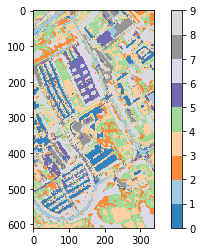

In [5]:
def label_show(im):
    cmap = cm.get_cmap('tab20c', 9)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=9)
    plt.colorbar(ticks=np.linspace(0,9,10))
    plt.show()
    
label_show(out_labels)